In [13]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [14]:
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

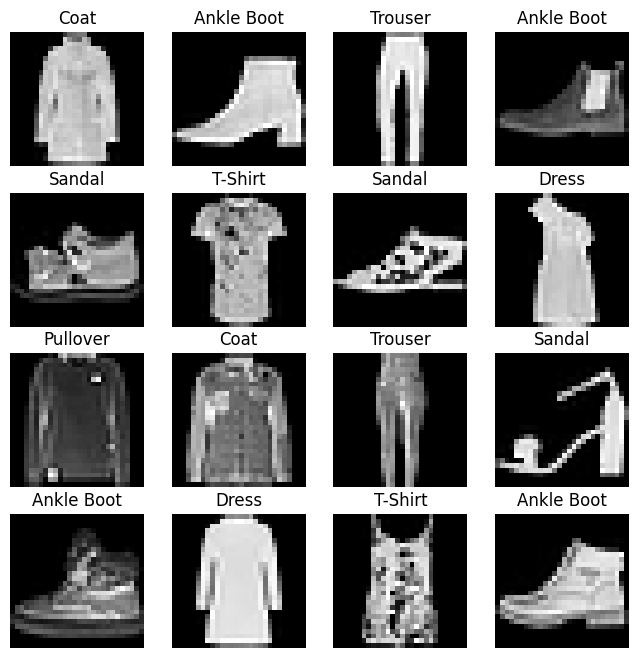

In [15]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
data_count = len(training_data.data)
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(data_count, size=(1,)).item())
    plt.subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(training_data.data[sample_idx], cmap="gray")
    plt.title(label=labels_map[int(training_data.targets[sample_idx].item())])
plt.show()

In [16]:
training_data_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [17]:
class NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        return self.fc2(
            F.dropout(
                F.relu(
                    self.fc1(
                        F.relu(
                            F.max_pool2d(
                            F.dropout(
                                    self.conv2(F.relu(F.max_pool2d(self.conv1(x), 2)))
                                ),
                                2,
                            )
                        ).view(-1, 4 * 4 * 50)
                    )
                ),
                training=self.training,
            )
        )
model = NET()

In [33]:
def train(epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1,epochs+1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(3, model, loss_fn, optimizer, training_data_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.190982
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.106395
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.157385
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.169691
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.232343
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.165741
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.225403
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.202837
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.307972
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.152315
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073791
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.287233
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.355497
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.161248
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.152539
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.078605
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.232713
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.153518
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.330673
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.238201
Train Epoch:

In [51]:
def test(model, loss_fn, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)
        )
    )
test(model, loss_fn, test_data_loader)


Test set: Average loss: 0.0042, Accuracy: 9105/10000 (91%)



In [52]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
